In [2]:
# 1. Setup Environment
!pip install transformers datasets scikit-learn tqdm matplotlib seaborn --quiet
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on {device}")


✅ Running on cpu


In [3]:
# 2. Import Helper Functions
from sklearn.metrics import confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, BertForSequenceClassification


C:\Users\AS\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 3. Load Fine-tuned BERT Model
model_path = 'outputs/outputs/fine_tuned_bert_mrpc'  # Adjust if needed
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
# 4. Load MRPC Test Set
dataset = load_dataset('glue', 'mrpc')

def tokenize_function(example):
    return tokenizer(example['sentence1'], example['sentence2'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

test_dataset = encoded_dataset['test']


In [6]:
# 5. Predict Logits for Test Set
@torch.no_grad()
def predict_logits(model, dataloader):
    model.eval()
    all_logits = []
    all_labels = []
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
    return torch.cat(all_logits), torch.cat(all_labels)

from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=32)
test_logits, test_labels = predict_logits(model, test_loader)


In [10]:
import torch

# Load saved calibration scores
all_calib_scores = torch.load('all_calib_scores.pt')

C:\Users\AS\AppData\Local\Temp\ipykernel_13508\2460207357.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_calib_scores = torch.load('all_calib_scores.pt')


In [11]:
# 6. Calculate P-values for Test Set
def calculate_pvalues(test_logits, calib_scores):
    pvalues = []
    for logit_vec in test_logits:
        p = []
        for class_idx in range(2):
            nonconf_score = -logit_vec[class_idx]
            p_val = (torch.sum(calib_scores <= nonconf_score).item() + 1) / (len(calib_scores) + 1)
            p.append(p_val)
        pvalues.append(p)
    return np.array(pvalues)

# Assuming you already have 'all_calib_scores' from ICP or XCP
pvalues = calculate_pvalues(test_logits, all_calib_scores)  # Use from your XCP or ICP


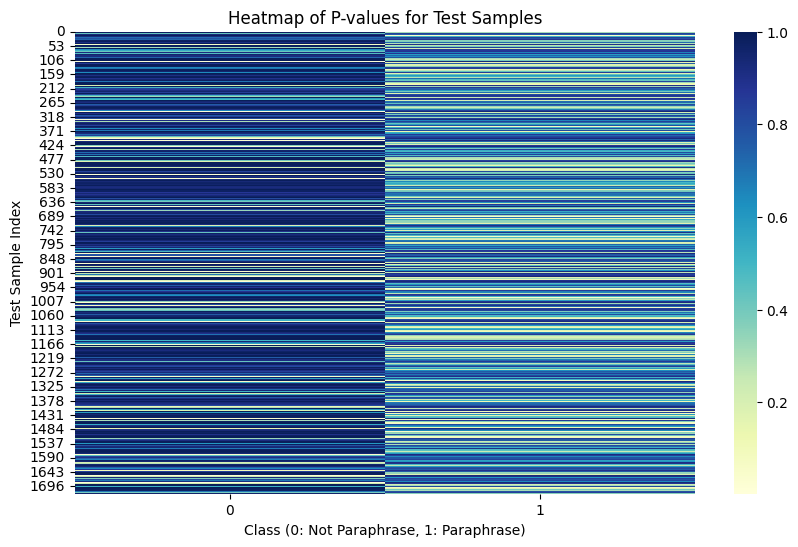

In [12]:
# 7. Plot Heatmap of P-Values
plt.figure(figsize=(10, 6))
sns.heatmap(pvalues, cmap="YlGnBu", cbar=True)
plt.title("Heatmap of P-values for Test Samples")
plt.xlabel("Class (0: Not Paraphrase, 1: Paraphrase)")
plt.ylabel("Test Sample Index")
plt.show()


In [13]:
# 8. Per-Class Coverage Analysis
# Define prediction sets
prediction_sets = []
epsilon = 0.1
for pv in pvalues:
    prediction = [i for i, p in enumerate(pv) if p > epsilon]
    prediction_sets.append(prediction)

# Analyze coverage
correct_singleton = 0
correct_any = 0
total = len(test_labels)

for i in range(total):
    if test_labels[i].item() in prediction_sets[i]:
        correct_any += 1
        if len(prediction_sets[i]) == 1:
            correct_singleton += 1

coverage_any = correct_any / total
coverage_singleton = correct_singleton / total

print(f"✅ Coverage (true label inside prediction set): {coverage_any:.4f}")
print(f"✅ Singleton Coverage (true label predicted alone): {coverage_singleton:.4f}")


✅ Coverage (true label inside prediction set): 0.9171
✅ Singleton Coverage (true label predicted alone): 0.0087


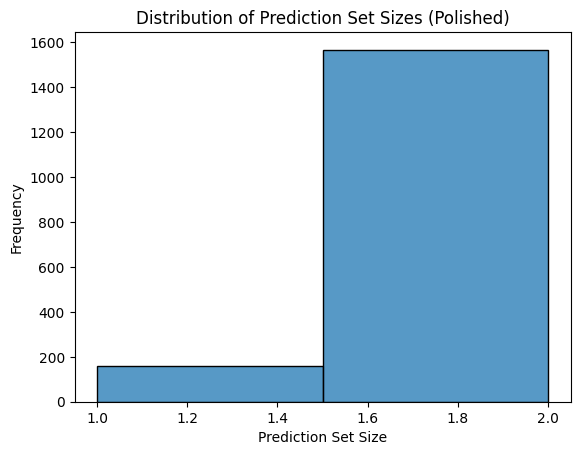

In [14]:
# 9. Clean Set Size Distribution Plot
set_sizes = [len(ps) for ps in prediction_sets]
sns.histplot(set_sizes, bins=2)
plt.title("Distribution of Prediction Set Sizes (Polished)")
plt.xlabel("Prediction Set Size")
plt.ylabel("Frequency")
plt.show()
